In [43]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing

import tensorflow as tf
from keras.optimizers import SGD
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline

In [14]:
#Import global confirmed cases
data = pd.read_csv('COVIDGlobalConfirmed.txt')
data = pd.concat([data.iloc[:, 1:2], data.iloc[:, 4:]], axis = 1)
data = data.set_index('Country/Region')

#Calculate new cases from total cases
data2 = data.diff(axis = 1).iloc[:, 1:]

#Keep only regions with more than 500 total cases
data3 = data2[data2.sum(axis = 1) > 500]

#Remove cruise ship assuming not representative of normal spread
data3 = data3[data3.index != 'Diamond Princess']

#Reshape data for plotting
data4 = data3.T.reset_index()
data4['index'] = pd.to_datetime(data4['index'])

In [15]:
#Create template for cleaning data
c1 = pd.concat([data4['index'], data4.iloc[:, 1:2]], axis = 1)
c1['country'] = c1.columns[1] + str(0)
c1.columns = ['index', 'new', 'country']
c1 = c1[c1['index'] >= c1[c1['new'] > 0]['index'].min()]
c1 = c1[c1['index'] <= c1[c1['new'] > 1]['index'].max()]
c1['prevTtl'] = c1['new'].cumsum() - c1['new']
c1['prevNew'] = c1.new.shift(1)
c1 = c1.fillna(0)
c1['rel2Peak'] = c1['index'] - c1[c1['new'] == c1['new'].max()]['index'].min()
r2p = []
for i in range(len(c1['rel2Peak'])):
    r = c1['rel2Peak'].iloc[i].days
    r2p.append(r)
c1['rel2Peak'] = r2p
c1['peak'] = c1[c1['new'] == c1['new'].max()]['new'].values[0]

#Clean and reshape data for plotting
forPlot = c1

for i in range(data4.shape[1] - 3):
    c = pd.concat([data4['index'], data4.iloc[:, i+2:i+3]], axis = 1)
    c['country'] = c.columns[1] + str(i+1)
    c.columns = ['index', 'new', 'country']
    c = c[c['index'] >= c[c['new'] > 0]['index'].min()]
    c = c[c['index'] <= c[c['new'] > 1]['index'].max()]
    c['prevTtl'] = c['new'].cumsum() - c['new']
    c['prevNew'] = c.new.shift(1)
    c = c.fillna(0)
    c['rel2Peak'] = c['index'] - c[c['new'] == c['new'].max()]['index'].min()
    r2p = []
    for k in range(len(c['rel2Peak'])):
        r = c['rel2Peak'].iloc[k].days
        r2p.append(r)
    c['rel2Peak'] = r2p
    c['peak'] = c[c['new'] == c['new'].max()]['new'].values[0]
    forPlot = pd.concat([forPlot, c])
    
#View a plot of the data
fig = px.scatter(forPlot, x='index', y='new', color = 'country', trendline="lowess")
fig.show()

In [4]:
#Seperate X and y for model fitting
forPlot.columns = ['date', 'new', 'country', 'prevTtl', 'prevNew', 'rel2Peak', 'peak']
forPlot = forPlot.reset_index()
forPlot.columns = ['day', 'date', 'new', 'country', 'prevTtl', 'prevNew', 'rel2Peak', 'peak']
X = pd.concat([forPlot['day'], forPlot.iloc[:, 4:]], axis = 1)
y = forPlot['new']

#Fit regular linear regression for base comparison
model = LinearRegression().fit(X, y)
p = model.predict(X)
mse = sum((y - p)**2)/len(p)
mae = sum(np.abs(y - p))/len(y)
R2 = model.score(X, y)

print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

MSE:  334895.7261315961 MAE:  110.47453939252405 R2:  0.8971645324436156


In [5]:
#Attempt linear regression after adding interaction terms
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(X)

model = LinearRegression().fit(X_inter, y)
p = model.predict(X_inter)
mse = sum((y - p)**2)/len(p)
mae = sum(np.abs(y - p))/len(y)
R2 = model.score(X_inter, y)

print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

MSE:  184310.7928878805 MAE:  94.26500669460346 R2:  0.9434042148544312


In [6]:
forPlot['country'].unique()

array(['Afghanistan0', 'Algeria1', 'Andorra2', 'Argentina3', 'Armenia4',
       'Australia5', 'Australia6', 'Australia7', 'Australia8', 'Austria9',
       'Azerbaijan10', 'Bahrain11', 'Belarus12', 'Belgium13',
       'Bosnia and Herzegovina14', 'Brazil15', 'Bulgaria16', 'Cameroon17',
       'Canada18', 'Canada19', 'Canada20', 'Canada21', 'Chile22',
       'China23', 'China24', 'China25', 'China26', 'China27', 'China28',
       'China29', 'China30', 'China31', 'China32', 'China33', 'China34',
       'China35', 'China36', 'China37', 'Colombia38', 'Costa Rica39',
       "Cote d'Ivoire40", 'Croatia41', 'Cuba42', 'Cyprus43', 'Czechia44',
       'Denmark45', 'Dominican Republic46', 'Ecuador47', 'Egypt48',
       'Estonia49', 'Finland50', 'France51', 'Germany52', 'Greece53',
       'Hungary54', 'Iceland55', 'India56', 'Indonesia57', 'Iran58',
       'Iraq59', 'Ireland60', 'Israel61', 'Italy62', 'Japan63',
       'Kazakhstan64', 'Korea, South65', 'Kuwait66', 'Latvia67',
       'Lebanon68', 'Li

MSE:  310.6358192328618 MAE:  12.45297671785344 R2:  -0.04037917905898958


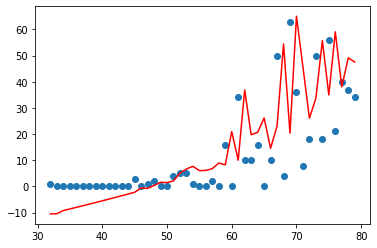

In [7]:
#Perform visual check on individual regions

#Isolate data for Afghanistan0
Afghanistan0 = forPlot[forPlot['country'] == 'Afghanistan0']

#Seperate xs and ys
X = pd.concat([Afghanistan0['day'], Afghanistan0.iloc[:, 4:]], axis = 1)
y = Afghanistan0['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

MSE:  6003009.024186919 MAE:  908.6973898287655 R2:  0.5032767408640402


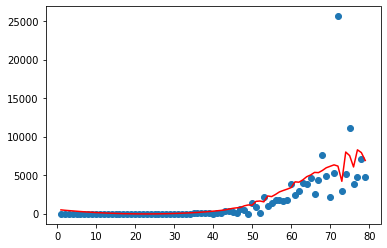

In [9]:
#Perform visual check on individual regions

#Isolate data for France51
France51 = forPlot[forPlot['country'] == 'France51']

#Seperate xs and ys
X = pd.concat([France51['day'], France51.iloc[:, 4:]], axis = 1)
y = France51['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

MSE:  1367844.4358731473 MAE:  738.077461899527 R2:  0.9892366397564301


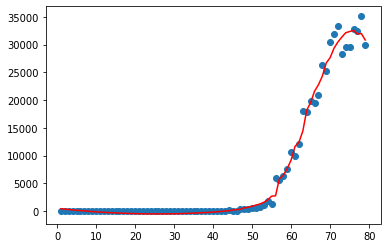

In [10]:
#Perform visual check on individual regions

#Isolate data for US104
US104 = forPlot[forPlot['country'] == 'US104']

#Seperate xs and ys
X = pd.concat([US104['day'], US104.iloc[:, 4:]], axis = 1)
y = US104['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

MSE:  5554.615994401802 MAE:  61.938492898650985 R2:  -5.086259748972594


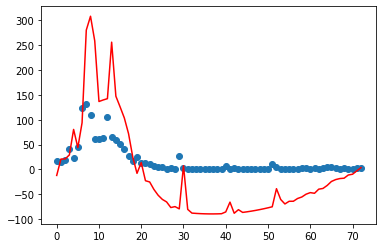

In [11]:
#Perform visual check on individual regions

#Isolate data for China37
China37 = forPlot[forPlot['country'] == 'China37']

#Seperate xs and ys
X = pd.concat([China37['day'], China37.iloc[:, 4:]], axis = 1)
y = China37['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

In [16]:
#Seperate X and y for model fitting
forPlot.columns = ['date', 'new', 'country', 'prevTtl', 'prevNew', 'rel2Peak', 'peak']
forPlot = forPlot.reset_index()
forPlot.columns = ['day', 'date', 'new', 'country', 'prevTtl', 'prevNew', 'rel2Peak', 'peak']
X = pd.concat([forPlot['day'], forPlot.iloc[:, 4:]], axis = 1)
y = forPlot['new']
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(X)


In [29]:
X = preprocessing.normalize(X_inter)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape = [X.shape[1]]))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse', 'mae'])

model.fit(X, y, epochs = 100)

Train on 5430 samples
Epoch 1/100
5430/5430 [==============================] - 1s 113us/sample - loss: 3358331.8356 - mse: 3358332.7500 - mae: 320.5811
Epoch 2/100
5430/5430 [==============================] - 0s 54us/sample - loss: 3341711.6285 - mse: 3341712.5000 - mae: 315.4670
Epoch 3/100
5430/5430 [==============================] - 0s 56us/sample - loss: 3301293.0247 - mse: 3301292.0000 - mae: 321.2922
Epoch 4/100
5430/5430 [==============================] - 0s 55us/sample - loss: 3245431.0774 - mse: 3245430.5000 - mae: 329.5731
Epoch 5/100
5430/5430 [==============================] - 0s 53us/sample - loss: 3173811.6504 - mse: 3173811.5000 - mae: 332.0557
Epoch 6/100
5430/5430 [==============================] - 0s 55us/sample - loss: 3092970.3822 - mse: 3092971.0000 - mae: 327.6044
Epoch 7/100
5430/5430 [==============================] - 0s 54us/sample - loss: 3014297.3747 - mse: 3014297.2500 - mae: 326.4958
Epoch 8/100
5430/5430 [==============================] - 0s 58us/sample - 

5430/5430 [==============================] - 0s 54us/sample - loss: 1961745.9759 - mse: 1961746.3750 - mae: 239.2366
Epoch 64/100
5430/5430 [==============================] - 0s 51us/sample - loss: 1953773.5556 - mse: 1953773.1250 - mae: 238.0268
Epoch 65/100
5430/5430 [==============================] - 0s 59us/sample - loss: 1946389.2757 - mse: 1946388.8750 - mae: 239.2289
Epoch 66/100
5430/5430 [==============================] - 0s 51us/sample - loss: 1941065.9176 - mse: 1941065.8750 - mae: 238.0620
Epoch 67/100
5430/5430 [==============================] - 0s 52us/sample - loss: 1932540.5797 - mse: 1932540.8750 - mae: 233.7681
Epoch 68/100
5430/5430 [==============================] - 0s 51us/sample - loss: 1928434.6317 - mse: 1928434.5000 - mae: 233.8919
Epoch 69/100
5430/5430 [==============================] - 0s 52us/sample - loss: 1919369.8563 - mse: 1919370.0000 - mae: 235.8121
Epoch 70/100
5430/5430 [==============================] - 0s 51us/sample - loss: 1913750.7276 - mse: 19

In [32]:
X = preprocessing.normalize(X_inter)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape = [X.shape[1]]))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mse', 'mae'])

model.fit(X, y, epochs = 100, batch_size = 50)

Train on 5430 samples
Epoch 1/100
5430/5430 [==============================] - 1s 93us/sample - loss: 322.1110 - mse: 3360192.0000 - mae: 322.1110
Epoch 2/100
5430/5430 [==============================] - 0s 35us/sample - loss: 318.1896 - mse: 3355038.5000 - mae: 318.1896
Epoch 3/100
5430/5430 [==============================] - 0s 36us/sample - loss: 311.0675 - mse: 3342631.2500 - mae: 311.0675
Epoch 4/100
5430/5430 [==============================] - 0s 38us/sample - loss: 305.6810 - mse: 3327809.5000 - mae: 305.6810
Epoch 5/100
5430/5430 [==============================] - 0s 40us/sample - loss: 300.3240 - mse: 3309281.2500 - mae: 300.3240
Epoch 6/100
5430/5430 [==============================] - 0s 38us/sample - loss: 295.4635 - mse: 3287443.2500 - mae: 295.4634
Epoch 7/100
5430/5430 [==============================] - 0s 36us/sample - loss: 291.8390 - mse: 3264588.2500 - mae: 291.8390
Epoch 8/100
5430/5430 [==============================] - 0s 36us/sample - loss: 289.0811 - mse: 3245631

5430/5430 [==============================] - 0s 35us/sample - loss: 210.6560 - mse: 2525948.5000 - mae: 210.6560
Epoch 66/100
5430/5430 [==============================] - 0s 32us/sample - loss: 209.8508 - mse: 2516256.5000 - mae: 209.8508
Epoch 67/100
5430/5430 [==============================] - 0s 34us/sample - loss: 209.1737 - mse: 2511469.0000 - mae: 209.1737
Epoch 68/100
5430/5430 [==============================] - 0s 33us/sample - loss: 208.4865 - mse: 2495423.0000 - mae: 208.4866
Epoch 69/100
5430/5430 [==============================] - 0s 34us/sample - loss: 207.7393 - mse: 2492948.7500 - mae: 207.7392
Epoch 70/100
5430/5430 [==============================] - 0s 33us/sample - loss: 207.0229 - mse: 2485376.7500 - mae: 207.0229
Epoch 71/100
5430/5430 [==============================] - 0s 34us/sample - loss: 206.4508 - mse: 2471925.2500 - mae: 206.4508
Epoch 72/100
5430/5430 [==============================] - 0s 34us/sample - loss: 205.6615 - mse: 2463257.0000 - mae: 205.6615
Epoch

In [33]:
X = preprocessing.normalize(X_inter)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape = [X.shape[1]]))
model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mse', 'mae'])

model.fit(X, y, epochs = 100, batch_size = 50)

Train on 5430 samples
Epoch 1/100
5430/5430 [==============================] - 1s 102us/sample - loss: 319.4436 - mse: 3356686.2500 - mae: 319.4435
Epoch 2/100
5430/5430 [==============================] - 0s 40us/sample - loss: 307.7137 - mse: 3331488.5000 - mae: 307.7138
Epoch 3/100
5430/5430 [==============================] - 0s 42us/sample - loss: 297.6675 - mse: 3293194.5000 - mae: 297.6675
Epoch 4/100
5430/5430 [==============================] - 0s 42us/sample - loss: 291.3610 - mse: 3259882.2500 - mae: 291.3611
Epoch 5/100
5430/5430 [==============================] - 0s 41us/sample - loss: 286.9701 - mse: 3228428.7500 - mae: 286.9701
Epoch 6/100
5430/5430 [==============================] - 0s 41us/sample - loss: 282.7876 - mse: 3201673.5000 - mae: 282.7876
Epoch 7/100
5430/5430 [==============================] - 0s 39us/sample - loss: 278.7222 - mse: 3174191.0000 - mae: 278.7222
Epoch 8/100
5430/5430 [==============================] - 0s 41us/sample - loss: 274.7822 - mse: 314823

5430/5430 [==============================] - 0s 40us/sample - loss: 178.9048 - mse: 2123255.2500 - mae: 178.9048
Epoch 66/100
5430/5430 [==============================] - 0s 37us/sample - loss: 178.3638 - mse: 2105331.2500 - mae: 178.3638
Epoch 67/100
5430/5430 [==============================] - 0s 35us/sample - loss: 177.9004 - mse: 2108363.0000 - mae: 177.9004
Epoch 68/100
5430/5430 [==============================] - 0s 36us/sample - loss: 177.2924 - mse: 2097929.2500 - mae: 177.2924
Epoch 69/100
5430/5430 [==============================] - 0s 36us/sample - loss: 176.6977 - mse: 2087938.6250 - mae: 176.6977
Epoch 70/100
5430/5430 [==============================] - 0s 36us/sample - loss: 175.8845 - mse: 2078939.1250 - mae: 175.8844
Epoch 71/100
5430/5430 [==============================] - 0s 36us/sample - loss: 175.7420 - mse: 2078460.3750 - mae: 175.7421
Epoch 72/100
5430/5430 [==============================] - 0s 37us/sample - loss: 174.9418 - mse: 2066226.6250 - mae: 174.9418
Epoch

In [34]:
X = preprocessing.normalize(X_inter)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape = [X.shape[1]]))
model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mse', 'mae'])

model.fit(X, y, epochs = 100, batch_size = 50)

Train on 5430 samples
Epoch 1/100
5430/5430 [==============================] - 1s 107us/sample - loss: 316.4595 - mse: 3351336.0000 - mae: 316.4594
Epoch 2/100
5430/5430 [==============================] - 0s 42us/sample - loss: 294.4559 - mse: 3274182.5000 - mae: 294.4560
Epoch 3/100
5430/5430 [==============================] - 0s 45us/sample - loss: 279.9719 - mse: 3175482.7500 - mae: 279.9719
Epoch 4/100
5430/5430 [==============================] - 0s 43us/sample - loss: 267.3102 - mse: 3083788.5000 - mae: 267.3102
Epoch 5/100
5430/5430 [==============================] - 0s 42us/sample - loss: 255.2616 - mse: 2981744.0000 - mae: 255.2616
Epoch 6/100
5430/5430 [==============================] - 0s 43us/sample - loss: 244.6101 - mse: 2877616.2500 - mae: 244.6101
Epoch 7/100
5430/5430 [==============================] - 0s 42us/sample - loss: 235.1330 - mse: 2783144.0000 - mae: 235.1331
Epoch 8/100
5430/5430 [==============================] - 0s 43us/sample - loss: 226.7409 - mse: 270241

5430/5430 [==============================] - 0s 42us/sample - loss: 153.5982 - mse: 1672096.0000 - mae: 153.5982
Epoch 66/100
5430/5430 [==============================] - 0s 37us/sample - loss: 153.5095 - mse: 1669922.6250 - mae: 153.5095
Epoch 67/100
5430/5430 [==============================] - 0s 40us/sample - loss: 153.4347 - mse: 1647717.5000 - mae: 153.4346
Epoch 68/100
5430/5430 [==============================] - 0s 38us/sample - loss: 156.4765 - mse: 1683569.3750 - mae: 156.4765
Epoch 69/100
5430/5430 [==============================] - 0s 40us/sample - loss: 156.5284 - mse: 1662346.8750 - mae: 156.5284
Epoch 70/100
5430/5430 [==============================] - 0s 41us/sample - loss: 152.5815 - mse: 1656301.8750 - mae: 152.5815
Epoch 71/100
5430/5430 [==============================] - 0s 39us/sample - loss: 153.4802 - mse: 1642159.0000 - mae: 153.4802
Epoch 72/100
5430/5430 [==============================] - 0s 38us/sample - loss: 153.5903 - mse: 1644428.2500 - mae: 153.5903
Epoch

In [35]:
X = preprocessing.scale(X_inter)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape = [X.shape[1]]))
model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mse', 'mae'])

model.fit(X, y, epochs = 100, batch_size = 50)

/Users/jmc517/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.



Train on 5430 samples
Epoch 1/100
5430/5430 [==============================] - 1s 115us/sample - loss: 312.4452 - mse: 3162793.2500 - mae: 312.4452
Epoch 2/100
5430/5430 [==============================] - 0s 43us/sample - loss: 196.0532 - mse: 1358064.5000 - mae: 196.0532
Epoch 3/100
5430/5430 [==============================] - 0s 45us/sample - loss: 108.6516 - mse: 328404.3750 - mae: 108.6516
Epoch 4/100
5430/5430 [==============================] - 0s 45us/sample - loss: 97.0407 - mse: 290034.8125 - mae: 97.0406
Epoch 5/100
5430/5430 [==============================] - 0s 43us/sample - loss: 91.5771 - mse: 269309.7500 - mae: 91.5771
Epoch 6/100
5430/5430 [==============================] - 0s 42us/sample - loss: 88.3772 - mse: 262437.9688 - mae: 88.3772
Epoch 7/100
5430/5430 [==============================] - 0s 48us/sample - loss: 89.1530 - mse: 286851.0000 - mae: 89.1531
Epoch 8/100
5430/5430 [==============================] - 0s 52us/sample - loss: 85.6678 - mse: 249372.3281 - mae: 8

5430/5430 [==============================] - 0s 43us/sample - loss: 75.6566 - mse: 227916.5156 - mae: 75.6566
Epoch 68/100
5430/5430 [==============================] - 0s 38us/sample - loss: 79.0940 - mse: 232279.8594 - mae: 79.0940
Epoch 69/100
5430/5430 [==============================] - 0s 37us/sample - loss: 76.6672 - mse: 218556.5781 - mae: 76.6672
Epoch 70/100
5430/5430 [==============================] - 0s 40us/sample - loss: 74.5129 - mse: 208088.4688 - mae: 74.5129
Epoch 71/100
5430/5430 [==============================] - 0s 38us/sample - loss: 74.0906 - mse: 210182.7344 - mae: 74.0906
Epoch 72/100
5430/5430 [==============================] - 0s 40us/sample - loss: 74.5233 - mse: 215091.8125 - mae: 74.5233
Epoch 73/100
5430/5430 [==============================] - 0s 37us/sample - loss: 75.3530 - mse: 212558.2188 - mae: 75.3530
Epoch 74/100
5430/5430 [==============================] - 0s 37us/sample - loss: 74.1739 - mse: 211401.4062 - mae: 74.1739
Epoch 75/100
5430/5430 [=====

In [36]:
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X_inter)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape = [X.shape[1]]))
model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mse', 'mae'])

model.fit(X, y, epochs = 100, batch_size = 50)

Train on 5430 samples
Epoch 1/100
5430/5430 [==============================] - 1s 108us/sample - loss: 319.6642 - mse: 3351164.7500 - mae: 319.6642
Epoch 2/100
5430/5430 [==============================] - 0s 42us/sample - loss: 313.0689 - mse: 3300197.7500 - mae: 313.0689
Epoch 3/100
5430/5430 [==============================] - 0s 46us/sample - loss: 293.2907 - mse: 2976791.7500 - mae: 293.2907
Epoch 4/100
5430/5430 [==============================] - 0s 43us/sample - loss: 250.8494 - mse: 2113793.5000 - mae: 250.8494
Epoch 5/100
5430/5430 [==============================] - 0s 43us/sample - loss: 182.1863 - mse: 848918.0000 - mae: 182.1863
Epoch 6/100
5430/5430 [==============================] - 0s 41us/sample - loss: 136.0648 - mse: 395994.6250 - mae: 136.0647
Epoch 7/100
5430/5430 [==============================] - 0s 43us/sample - loss: 126.0383 - mse: 355628.4688 - mae: 126.0383
Epoch 8/100
5430/5430 [==============================] - 0s 45us/sample - loss: 122.6949 - mse: 347835.81

5430/5430 [==============================] - 0s 43us/sample - loss: 85.7737 - mse: 282554.0312 - mae: 85.7737
Epoch 68/100
5430/5430 [==============================] - 0s 38us/sample - loss: 85.6092 - mse: 278190.2812 - mae: 85.6092
Epoch 69/100
5430/5430 [==============================] - 0s 39us/sample - loss: 85.3366 - mse: 280182.3438 - mae: 85.3366
Epoch 70/100
5430/5430 [==============================] - 0s 41us/sample - loss: 85.6578 - mse: 289080.1562 - mae: 85.6579
Epoch 71/100
5430/5430 [==============================] - 0s 39us/sample - loss: 86.4833 - mse: 280879.7188 - mae: 86.4833
Epoch 72/100
5430/5430 [==============================] - 0s 40us/sample - loss: 86.1434 - mse: 280637.7812 - mae: 86.1434
Epoch 73/100
5430/5430 [==============================] - 0s 39us/sample - loss: 84.8000 - mse: 281505.3438 - mae: 84.8000
Epoch 74/100
5430/5430 [==============================] - 0s 41us/sample - loss: 85.6019 - mse: 275841.5938 - mae: 85.6019
Epoch 75/100
5430/5430 [=====

In [37]:
X = preprocessing.scale(X_inter)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape = [X.shape[1]]))
model.add(tf.keras.layers.Dense(1000, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse', 'mae'])

model.fit(X, y, epochs = 100, batch_size = 50)

/Users/jmc517/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.



Train on 5430 samples
Epoch 1/100
5430/5430 [==============================] - 1s 145us/sample - loss: 2678448.0034 - mse: 2678447.7500 - mae: 308.5335
Epoch 2/100
5430/5430 [==============================] - 0s 75us/sample - loss: 551354.1592 - mse: 551354.2500 - mae: 231.9945
Epoch 3/100
5430/5430 [==============================] - 0s 69us/sample - loss: 337616.2600 - mse: 337616.1562 - mae: 160.0425
Epoch 4/100
5430/5430 [==============================] - ETA: 0s - loss: 269283.1162 - mse: 269283.1875 - mae: 128.986 - 0s 67us/sample - loss: 324803.4893 - mse: 324803.5938 - mae: 134.2668
Epoch 5/100
5430/5430 [==============================] - 0s 77us/sample - loss: 292720.6678 - mse: 292720.7188 - mae: 119.5160
Epoch 6/100
5430/5430 [==============================] - 0s 69us/sample - loss: 283209.6238 - mse: 283209.6562 - mae: 110.1503
Epoch 7/100
5430/5430 [==============================] - 0s 75us/sample - loss: 274000.6852 - mse: 274000.6562 - mae: 102.8719
Epoch 8/100
5430/5430 

5430/5430 [==============================] - 0s 69us/sample - loss: 173957.3648 - mse: 173957.3281 - mae: 88.1946
Epoch 65/100
5430/5430 [==============================] - 0s 62us/sample - loss: 202516.8118 - mse: 202516.7969 - mae: 94.6041
Epoch 66/100
5430/5430 [==============================] - 0s 63us/sample - loss: 165651.4162 - mse: 165651.3594 - mae: 86.0364
Epoch 67/100
5430/5430 [==============================] - 0s 67us/sample - loss: 170023.5331 - mse: 170023.4688 - mae: 84.8359
Epoch 68/100
5430/5430 [==============================] - 0s 62us/sample - loss: 167758.8569 - mse: 167758.8906 - mae: 85.06300s - loss: 106097.8246 - mse: 106097.8281 - mae: 84.50 - ETA: 0s - loss: 122930.1858 - mse: 122930.1875 - mae:
Epoch 69/100
5430/5430 [==============================] - 0s 58us/sample - loss: 169101.3704 - mse: 169101.3594 - mae: 84.7683
Epoch 70/100
5430/5430 [==============================] - 0s 61us/sample - loss: 181400.7420 - mse: 181400.7188 - mae: 90.4583
Epoch 71/100
5

In [45]:
trainX, testX = X[:-13], X[-13:]
trainy, testy = y[:-13], y[-13:]

n_input = 13
n_features = 25

generator = TimeseriesGenerator(trainX, trainX, length = n_input, batch_size = 10)

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape = (n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(n_features))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs = 10)

Epoch 1/10
541/541 [==============================] - 11s 20ms/step - loss: 1.1396
Epoch 2/10
541/541 [==============================] - 9s 18ms/step - loss: 0.3019
Epoch 3/10
541/541 [==============================] - 10s 18ms/step - loss: 0.2497
Epoch 4/10
541/541 [==============================] - 10s 18ms/step - loss: 2.1902
Epoch 5/10
541/541 [==============================] - 10s 18ms/step - loss: 0.4013
Epoch 6/10
541/541 [==============================] - 10s 18ms/step - loss: 0.3998
Epoch 7/10
541/541 [==============================] - 10s 18ms/step - loss: 0.3510
Epoch 8/10
541/541 [==============================] - 10s 18ms/step - loss: 0.3951
Epoch 9/10
541/541 [==============================] - 10s 19ms/step - loss: 0.2602
Epoch 10/10
541/541 [==============================] - 10s 18ms/step - loss: 0.1753
